In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')
import os
import random
import tensorflow as tf

# For reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


avg_df = pd.read_csv("participants_with_date_index.csv")
avg_df.columns = avg_df.columns.str.strip()
avg_df['Date Created'] = pd.to_datetime(avg_df['Date Created'], format='mixed', dayfirst=True, errors='coerce')

bird_counts = avg_df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
print(f"Most frequently seen bird: {most_frequent_bird}")

filtered_df = avg_df[avg_df['Bird Name'] == most_frequent_bird]
participants_per_day = filtered_df.groupby('Date Created')['Participant Name'].nunique()
total_birds_per_day = filtered_df.groupby('Date Created')['Number of Birds'].sum()
average_birds_per_participant = total_birds_per_day / participants_per_day

values = average_birds_per_participant.values.astype('float32').reshape(-1, 1)
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

Most frequently seen bird: Eurasian Tree Sparrow


In [2]:
# Dataset creation
def create_dataset(data, window_size, forecast_steps=1):
    X, Y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size:i + window_size + forecast_steps])
    return np.array(X), np.array(Y)

# Train and predict function
def train_and_predict(model, model_name, values_scaled, window_size, regenerate_points, future_steps):

    # Create dataset
    X, Y = create_dataset(values_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test), shuffle=False)

    # Regeneration
    regen_pred_actual = []
    for i in range(window_size):
        regen_pred_actual.append(values_scaled[i][0])
    for i in range(regenerate_points - window_size):
        input_window = values_scaled[i:i + window_size].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        regen_pred_actual.append(pred)

    # Future prediction
    future_input = values_scaled[regenerate_points - window_size:regenerate_points]
    future_predictions = []
    for _ in range(future_steps):
        input_window = future_input[-window_size:].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input[1:], pred)

    # Inverse transform
    regen_pred_actual = scaler.inverse_transform(np.array(regen_pred_actual).reshape(-1, 1))
    future_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    regen_pred_actual[regen_pred_actual < 0] = 0
    future_actual[future_actual < 0] = 0

    # Metrics
    true_values = values[window_size:regenerate_points]
    predicted_values = regen_pred_actual[window_size:regenerate_points]
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = mean_absolute_percentage_error(true_values, predicted_values) * 100

    print(f"\n Model: {model_name}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return regen_pred_actual, future_actual

In [3]:
# Parameters
window_size = 60
regenerate_points = 150
future_steps = 150

# Model D - Two LSTM layers only
model_d = Sequential()
model_d.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model_d.add(LSTM(64))
model_d.add(Dense(1))
model_d.compile(loss='mean_squared_error', optimizer='adam')

# Train and collect predictions
regen_d, future_d = train_and_predict(model_d, "Two-Layer", values_scaled, window_size, regenerate_points, future_steps)

# Save data into txt file
np.savetxt('regen_d.txt', regen_d,fmt='%12.6e')
np.savetxt('future_d.txt', future_d,fmt='%12.6e')



 Model: Two-Layer
MSE: 5.4690
RMSE: 2.3386
MAE: 1.8213
MAPE: 35.30%


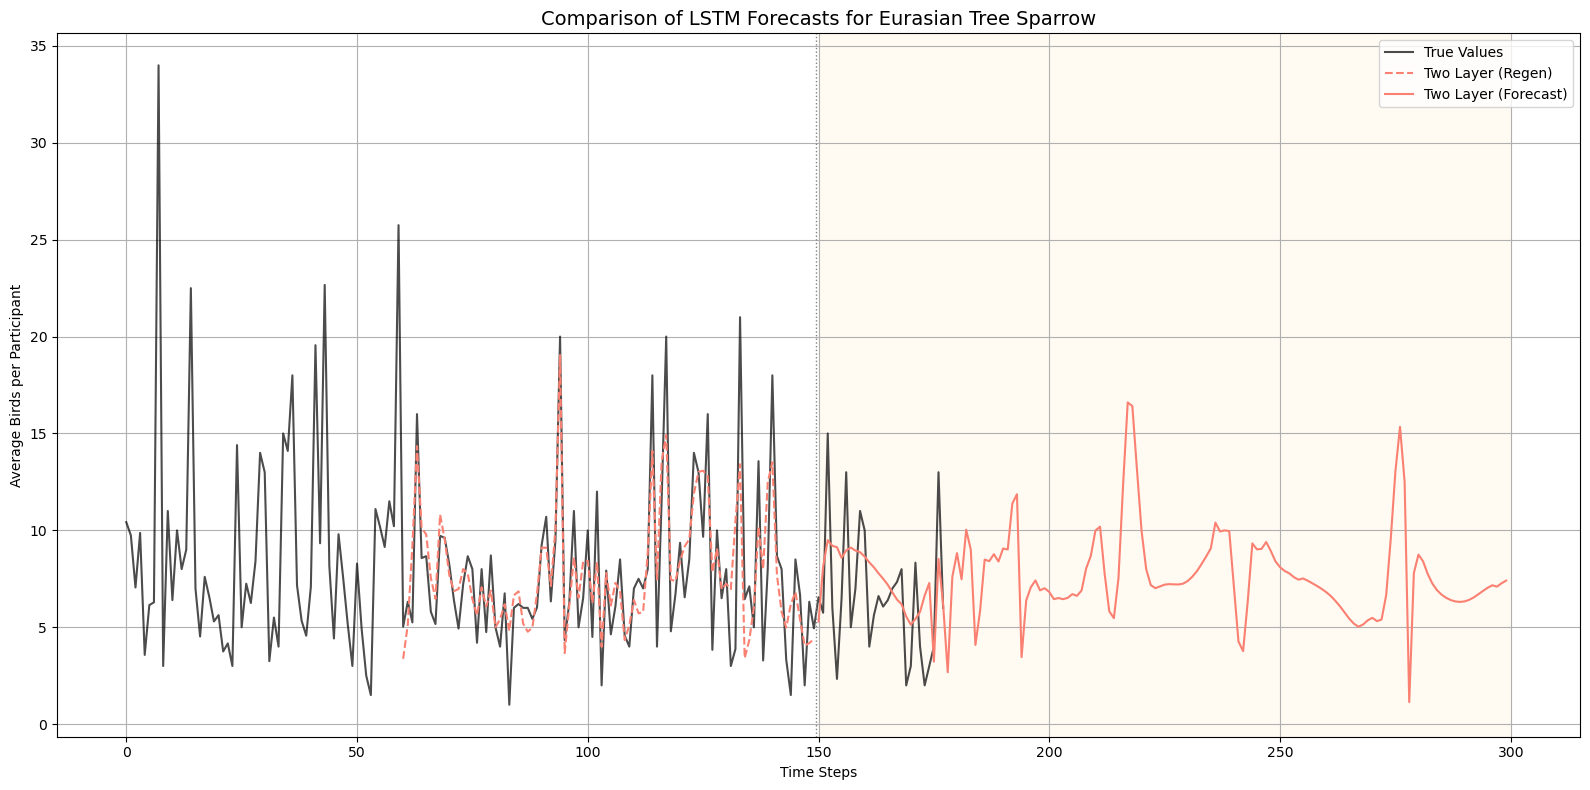

In [4]:
# Plotting
plt.figure(figsize=(16, 8))
plt.plot(values, label='True Values', color='black', alpha=0.7)

plt.plot(range(window_size, regenerate_points), regen_d[window_size:], '--', label='Two Layer (Regen)', color='salmon')

future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_d, label='Two Layer (Forecast)', color='salmon')

plt.axvline(x=regenerate_points - 0.5, color='gray', linestyle=':', linewidth=1)
plt.axvspan(future_start, future_end, color='orange', alpha=0.05)
plt.title(f'Comparison of LSTM Forecasts for {most_frequent_bird}', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Average Birds per Participant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
